In [1]:
import IPython.display as ipd
from PIL import Image
import lib6300
import matplotlib.pyplot as plt
import numpy as np
import cv2

Helpers

In [45]:
def read_bytes_list(file_path):
  file_bytes = []
  with open(file_path, 'rb') as file:
    byte = file.read(1)
    while byte:
      file_bytes.append(byte)
      byte = file.read(1)
  return file_bytes

def bytes2samples16(bytes):
  # convert bytes to 16-bit samples
  sample_bytes = [a + b for a, b in zip(bytes[::2], bytes[1::2])]
  # convert sample bytes to integers
  samples = [int.from_bytes(sample, byteorder='little', signed=True) for sample in sample_bytes]
  # normalize to [-1, 1]
  samples_normalized = [sample / 32768 for sample in samples] # 32768 = 2^15
  return samples_normalized

def samples162bytes(samples):
  # convert samples to 16-bit bytes
  samples = [int(sample * 32768) for sample in samples] # 32768 = 2^15
  sample_bytes = [sample.to_bytes(2, byteorder='little', signed=True) for sample in samples]
  # flatten list of bytes
  bytes = [byte for sample in sample_bytes for byte in sample]
  return bytes

def save_bytes2mem16(bytes, file_path):
  # write to .mem file with 2 bytes per line
  with open(file_path, 'w') as file:
    for i in range(0, len(bytes), 2):
      file.write(f"{bytes[i]:02x}{bytes[i+1]:02x}\n")

def bytes2samples24(bytes):
  # convert bytes to 24-bit samples
  sample_bytes = [a + b + c for a, b, c in zip(bytes[::3], bytes[1::3], bytes[2::3])]
  # convert sample bytes to integers
  samples = [int.from_bytes(sample, byteorder='little', signed=True) for sample in sample_bytes]
  # normalize to [-1, 1]
  samples_normalized = [sample / 8388608 for sample in samples] # 8388608 = 2^23
  return samples_normalized

In [3]:
def select(samples, start, width):
  return samples[start:(start+width)]

def oscillate(samples):
  # tile till it fits 360x720
  samples = np.array(samples)
  if len(samples) < 360 * 720:
    samples = np.tile(samples, int(360 * 720 / len(samples)) + 1)
    
  samples = samples[:360 * 720] # on FPGA, wont need to crop
  return samples

In [4]:
def make_frames(samples, duration, fps=24):
  frames = []

  samples = np.array(samples)
  # repeat and rotate the samples for the duration in sec
  for i in range(duration * 44100):
    if i % int(44100/fps) == 0:
      frame = np.roll(samples, i)
      frames.append(frame)
  return frames


def create_grayscale_video(frames, output_path, fps=24):
    # Get the dimensions of the first frame
    height, width = 360, 720

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)

    # Convert each frame to grayscale and write to the video
    for frame in frames:
        frame = cv2.normalize(frame.reshape(360, 720), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        out.write(frame)

    # Release the VideoWriter
    out.release()


def create_color_video(rgb_frames, output_path, fps=24):
    # each frame is a 1D array of RGB values. Make each RGB frame 3x360x720
    height, width = 10, 10

    # Create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

    # Generate video frames
    for rgb in rgb_frames:
        rgb_8bit = (np.array(rgb) * 255).astype(np.uint8)
        # Create a solid color frame
        frame = np.zeros((height, width, 3), dtype=np.uint8)
        frame[:,:] = rgb_8bit  # Fill the frame with the RGB color
        out.write(frame)  # Write frame to video

    # Release the VideoWriter
    out.release()


def get_freq_frames(frames):
  LOOKAHEAD = 100

  frames_freqs = []

  # run FFT on each frame
  for frame in frames:
    frames_freqs.append(np.fft.fft(frame[:LOOKAHEAD], 100)[:50])
  frames_freqs = np.array(frames_freqs)

  # into 3 frequency bands
  frames_freqs3 = np.zeros((len(frames_freqs), 3))
  frames_freqs3[:, 0] = np.mean(np.abs(frames_freqs[:, 0:5]), axis=1)
  frames_freqs3[:, 1] = np.mean(np.abs(frames_freqs[:, 5:20]), axis=1)
  frames_freqs3[:, 2] = np.mean(np.abs(frames_freqs[:, 20:50]), axis=1)

  # normalize
  frames_freqs3 = frames_freqs3 / np.max(frames_freqs3)

  return frames_freqs3

# Audio

Conversion:

ffmpeg -i track.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f s16le track.raw

In [ ]:
# print(0b00111111111111100000)
print(0b111111111111111100)
print(360*720)

262112
262140
259200


File types:

In [5]:
# RAW
START_ADDR = 0
WIDTH = 0b111111111111110000

bytes = read_bytes_list("track.raw")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

print(bytes[:60])

display(ipd.Audio(selected_samples, rate=44100))

[b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00']


In [38]:
# RAW
START_ADDR = 400000
WIDTH = 262141

bytes = read_bytes_list("track.raw")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

print(selected_samples[:60])

display(ipd.Audio(selected_samples, rate=44100))

[0.126617431640625, 0.120086669921875, 0.112548828125, 0.105743408203125, 0.0980224609375, 0.09075927734375, 0.0838623046875, 0.076934814453125, 0.07025146484375, 0.060943603515625, 0.05621337890625, 0.049468994140625, 0.03790283203125, 0.033966064453125, 0.028228759765625, 0.020538330078125, 0.013519287109375, 0.004974365234375, -0.001861572265625, -0.0113525390625, -0.0169677734375, -0.022369384765625, -0.031768798828125, -0.04132080078125, -0.04730224609375, -0.048095703125, -0.054351806640625, -0.062774658203125, -0.07391357421875, -0.0816650390625, -0.087005615234375, -0.099700927734375, -0.10430908203125, -0.106842041015625, -0.113037109375, -0.119415283203125, -0.12835693359375, -0.134918212890625, -0.1416015625, -0.14794921875, -0.15484619140625, -0.162322998046875, -0.16827392578125, -0.1746826171875, -0.18096923828125, -0.187164306640625, -0.19366455078125, -0.20062255859375, -0.20654296875, -0.21295166015625, -0.21942138671875, -0.225830078125, -0.233154296875, -0.2384033203

In [46]:
bytes = samples162bytes(selected_samples)
save_bytes2mem16(bytes, "track.mem")

In [7]:
# WAV
START_ADDR = 0
WIDTH = 0b111111111111110000

bytes = read_bytes_list("track.wav")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

print(bytes[:60])

display(ipd.Audio(selected_samples, rate=44100))

[b'R', b'I', b'F', b'F', b'\xca', b'\xb1', b'\xbc', b'\x01', b'W', b'A', b'V', b'E', b'f', b'm', b't', b' ', b'\x10', b'\x00', b'\x00', b'\x00', b'\x01', b'\x00', b'\x01', b'\x00', b'D', b'\xac', b'\x00', b'\x00', b'\x88', b'X', b'\x01', b'\x00', b'\x02', b'\x00', b'\x10', b'\x00', b'L', b'I', b'S', b'T', b'\x9e', b'\x00', b'\x00', b'\x00', b'I', b'N', b'F', b'O', b'I', b'A', b'R', b'T', b'\x07', b'\x00', b'\x00', b'\x00', b'K', b'-', b'L', b'o']


In [9]:
# MP3
START_ADDR = 0
WIDTH = 0b111111111111110000

bytes = read_bytes_list("track.mp3")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

print(bytes[:60])

display(ipd.Audio(selected_samples, rate=44100))

[b'I', b'D', b'3', b'\x03', b'\x00', b'\x00', b'\x00', b'\x07', b'9', b'<', b'T', b'I', b'T', b'2', b'\x00', b'\x00', b'\x00', b'+', b'\x00', b'\x00', b'\x01', b'\xff', b'\xfe', b'Y', b'\x00', b'e', b'\x00', b'a', b'\x00', b'h', b'\x00', b' ', b'\x00', b'Y', b'\x00', b'e', b'\x00', b'a', b'\x00', b'h', b'\x00', b' ', b'\x00', b'Y', b'\x00', b'e', b'\x00', b'a', b'\x00', b'h', b'\x00', b' ', b'\x00', b'Y', b'\x00', b'e', b'\x00', b'a', b'\x00', b'h']


In [10]:
# HEIC
START_ADDR = 0
WIDTH = 0b111111111111110000

bytes = read_bytes_list("img.HEIC")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

print(bytes[:60])

display(ipd.Audio(selected_samples, rate=44100))

[b'\x00', b'\x00', b'\x00', b'(', b'f', b't', b'y', b'p', b'h', b'e', b'i', b'c', b'\x00', b'\x00', b'\x00', b'\x00', b'm', b'i', b'f', b'1', b'M', b'i', b'H', b'E', b'M', b'i', b'P', b'r', b'm', b'i', b'a', b'f', b'M', b'i', b'H', b'B', b'h', b'e', b'i', b'c', b'\x00', b'\x00', b'\x12', b'\x16', b'm', b'e', b't', b'a', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'\x00', b'!', b'h', b'd', b'l', b'r']


Oscillate

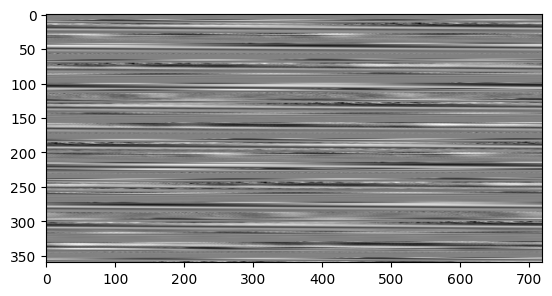

In [ ]:
bytes = read_bytes_list("track.raw")
samples = bytes2samples16(bytes)
# selected_samples = select(samples, 0, 0b00111111111111100000) # 262112 samples
selected_samples = select(samples, 20000, 0b111111111111100000)

# Audio
osc_samples = oscillate(selected_samples)
display(ipd.Audio(osc_samples, rate=44100))

# Image
plt.imshow(osc_samples.reshape(360, 720), cmap='gray')

# Video
frames = make_frames(osc_samples, 4)
create_grayscale_video(frames, 'video1.mp4', fps=24)

# Color Video
rgb_frames = get_freq_frames(frames)
create_color_video(rgb_frames, 'fft2.mp4', fps=24)

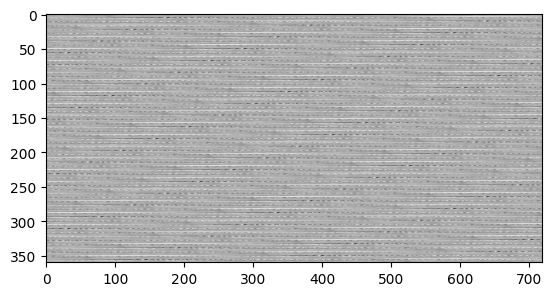

In [7]:
bytes = read_bytes_list("track.raw")
samples = bytes2samples16(bytes)
# selected_samples = select(samples, 0, 0b00111111111111100000) # 262112 samples
selected_samples = select(samples, 20000, 0b111111100000)

# Audio
osc_samples = oscillate(selected_samples)
display(ipd.Audio(osc_samples, rate=44100))

# Image
plt.imshow(osc_samples.reshape(360, 720), cmap='gray')

# Video
frames = make_frames(osc_samples, 4)
create_grayscale_video(frames, 'video11.mp4', fps=24)

# Color Video
rgb_frames = get_freq_frames(frames)
create_color_video(rgb_frames, 'fft11.mp4', fps=24)

# Images

Conversion:

In [34]:
def img2raw(path):
  image = Image.open(path)
  image = image.resize((720, 360)).convert('L') # resize and convert to grayscale

  img_bytes = []
  for byte in image.tobytes():
    img_bytes.append(b'\x00')
    img_bytes.append(byte.to_bytes(1, 'little'))

  # img_bytes = np.array(list(image.tobytes()))
  # img_int16 = img_bytes.view(np.uint16)
  
  # write file as filename.raw
  filename = path.split('.')[0] + '.raw'
  with open(filename, 'wb') as file:
    for byte in img_bytes:
      file.write(byte)

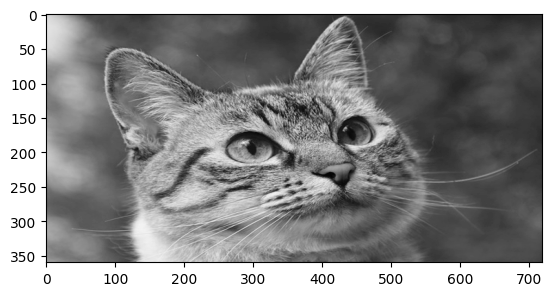

In [35]:
# Convert an image to raw
img2raw("cat.jpg")

# Open the image
image = Image.open("cat.jpg")
new_image = image.resize((720, 360)).convert('L')
plt.imshow(new_image, cmap='gray')

Processing:

In [9]:
START_ADDR = 0
WIDTH = 0b111111111111110000

bytes = read_bytes_list("cat.raw")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

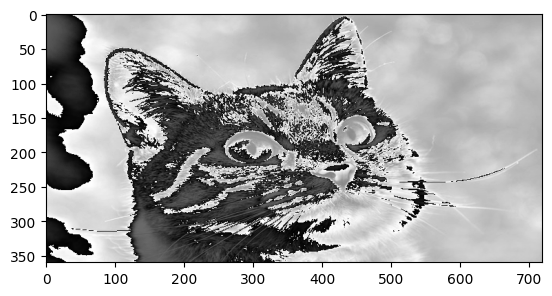

In [10]:
# Audio
osc_samples = oscillate(selected_samples)
display(ipd.Audio(osc_samples, rate=44100))

# Image
plt.imshow(osc_samples.reshape(360, 720), cmap='gray')

# Video
frames = make_frames(osc_samples, 4)
create_grayscale_video(frames, 'video2.mp4', fps=24)

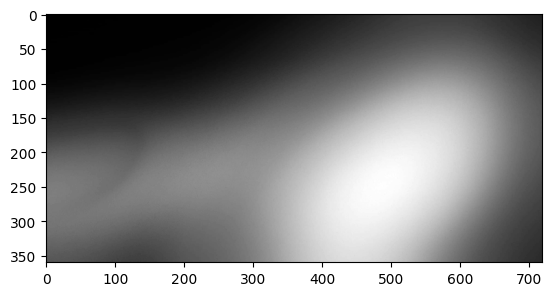

In [ ]:
# Convert an image to raw
img2raw("gradient.jpg")

# Open the image
image = Image.open("gradient.jpg")
new_image = image.resize((720, 360)).convert('L')
plt.imshow(new_image, cmap='gray')

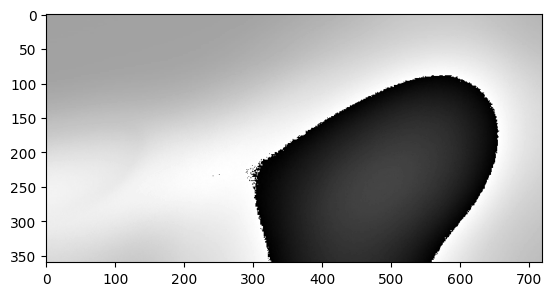

In [70]:
START_ADDR = 0
WIDTH = 0b111111111111110000

bytes = read_bytes_list("gradient.raw")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

# Audio
osc_samples = oscillate(selected_samples)
display(ipd.Audio(osc_samples, rate=44100))

# Image
plt.imshow(osc_samples.reshape(360, 720), cmap='gray')

# Video
frames = make_frames(osc_samples, 4)
create_grayscale_video(frames, 'video2.mp4', fps=24)

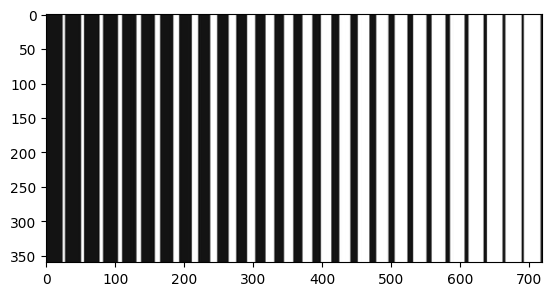

In [41]:
# Convert an image to raw
img2raw("lines.jpg")

# Open the image
image = Image.open("lines.jpg")
new_image = image.resize((720, 360)).convert('L')
plt.imshow(new_image, cmap='gray')

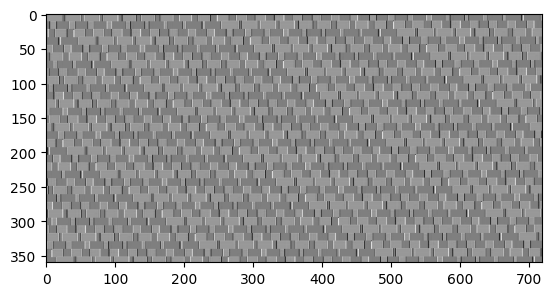

In [11]:
START_ADDR = 0
WIDTH = 0b1111111110000

bytes = read_bytes_list("lines.raw")
samples = bytes2samples16(bytes)
selected_samples = select(samples, START_ADDR, WIDTH)

# Audio
osc_samples = oscillate(selected_samples)
display(ipd.Audio(osc_samples, rate=44100))

# Image
plt.imshow(osc_samples.reshape(360, 720), cmap='gray')

# Video
frames = make_frames(osc_samples, 4)
create_grayscale_video(frames, 'video3.mp4', fps=24)

# FFT?

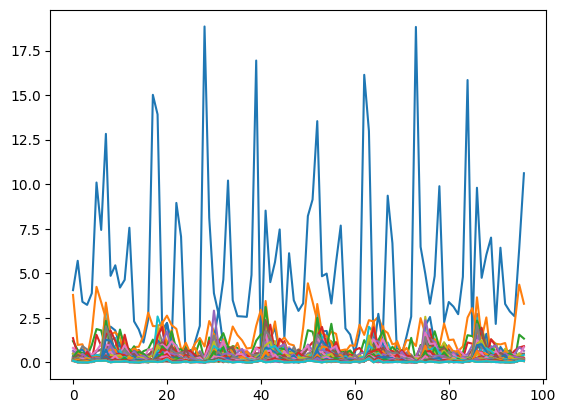

In [129]:
LOOKAHEAD = 100

frames_freqs = []

for frame in frames:
  frames_freqs.append(np.fft.fft(frame[:LOOKAHEAD], 100)[:50])
frames_freqs = np.array(frames_freqs)

plt.plot(np.abs(frames_freqs))

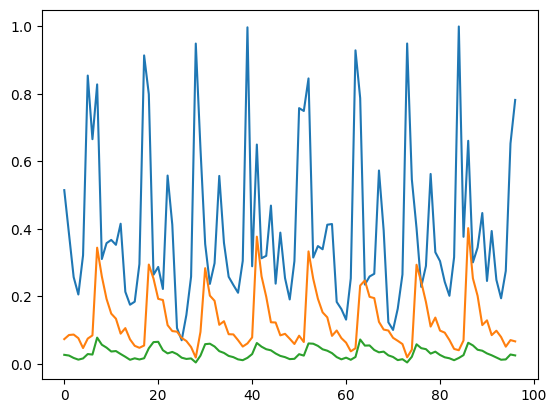

In [130]:
frames_freqs3 = np.zeros((len(frames_freqs), 3))
frames_freqs3[:, 0] = np.mean(np.abs(frames_freqs[:, 0:5]), axis=1)
frames_freqs3[:, 1] = np.mean(np.abs(frames_freqs[:, 5:20]), axis=1)
frames_freqs3[:, 2] = np.mean(np.abs(frames_freqs[:, 20:50]), axis=1)
# normalize
frames_freqs3 = frames_freqs3 / np.max(frames_freqs3)

plt.plot(frames_freqs3)

Questions:

USB vs SD
BRAM: 2 reads (selection + play-pointer) and 1 write?

How to write to SD